<a href="https://colab.research.google.com/github/haoboooo/Temporal-Effect-of-Sentiment-Analysis/blob/main/software_unbalance_merge_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [1]:
# install emoji library
!pip install emot

     |████████████████████████████████| 61 kB 20 kB/s 


In [2]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Please install GPU version of TF
True
2.8.0
2.8.0


In [4]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load software data

In [8]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/software/98_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/software/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/software/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/software/18.csv"

In [9]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(27028, 3)
 1.0    13613
-1.0    11120
 0.0     2295
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,-Great devotional Bible written with easy-to-u...
1,1.0,2006,I love the new king james version of the the l...
2,1.0,2005,I highly recommend this version of the bible f...
3,1.0,2005,This Bible is a great study help. The comment...
4,1.0,2005,Great Bible for study - very informative and t...


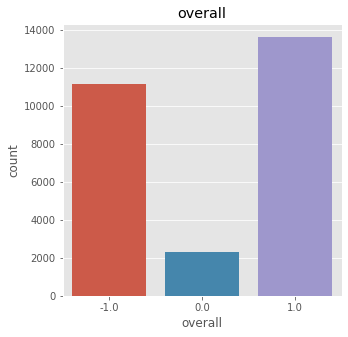

In [10]:
# load data for 1998 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(83773, 3)
 1.0    48362
-1.0    27920
 0.0     7491
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2011,"Strong backgroung, good read, quite up to date..."
1,0.0,2010,If you live on Mars and never heard of the int...
2,1.0,2010,i got this book on amazon and it ended up savi...
3,1.0,2010,I was very happy with this purchase because th...
4,1.0,2010,Recieved in a timely manner- book in great con...


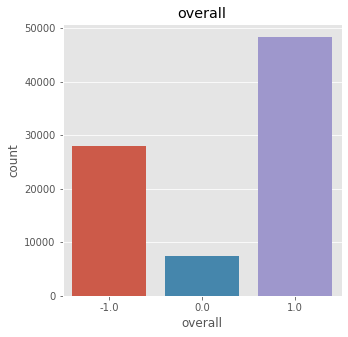

In [11]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(235021, 3)
 1.0    146179
-1.0     69066
 0.0     19776
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,The materials arrived early and were in excell...
1,1.0,2014,I am really enjoying this book with the worksh...
2,-1.0,2014,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,0.0,2014,This book was missing pages!!! Important pages...
4,1.0,2013,I have used LearnSmart and can officially say ...


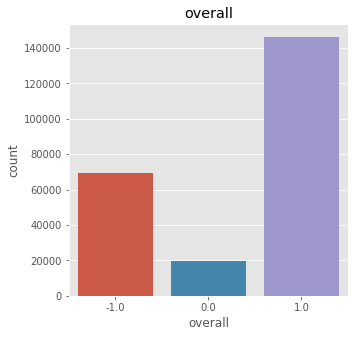

In [12]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(10435, 3)
 1.0    5925
-1.0    3732
 0.0     778
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2018,Product had false key. Fake Microsoft phone n...
1,1.0,2018,the codes worked fine. Im not really a fan of...
2,1.0,2018,This product was good i loved that i was able ...
3,1.0,2018,It is just a must have for your computer what ...
4,1.0,2018,Having access on more than one device helps.


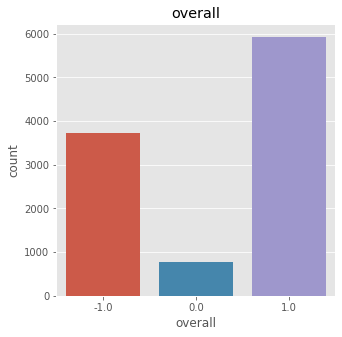

In [13]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5900 positive，3700 negative，770 neutral

80%(8056) training and 20%(2314) testing

In [14]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4480,:]
  train_neudata = neu.iloc[:616,:]
  train_negdata = neg.iloc[:2960,:]

  # split to get test for each class
  test_posdata = pos.iloc[4480:5900,:]
  test_neudata = neu.iloc[616:770,:]
  test_negdata = neg.iloc[2960:3700,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [15]:
# data for 1998 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [16]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [17]:
df4_train.head()

,overall,reviewTime,reviewText
7968,1.0,2018,My 10 year old LOVES this and spends hours a w...
3652,1.0,2018,"Love it. I can read my books on my computer, ..."
1684,2.0,2018,It worked fine for the first few days. But af...
10627,2.0,2018,product does not give enough info about produc...
1089,1.0,2018,Sounds great!


## Text Preprocessing

In [18]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [19]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [20]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [21]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [22]:
df4_test.head()

,overall,reviewTime,reviewText,cleanText
14,1.0,2018,Glad for the coverage.,glad coverage
1562,1.0,2018,Love it it has already identified a virus on a...,love identified virus website thought safe
6235,2.0,2018,"Since I bought it through Amazon, and after in...",bought amazon installing needed registration k...
6351,1.0,2018,Love this software.,love software
3014,1.0,2018,It works very well.,works well


## Merge train&test data

In [23]:
def merge(df1,df2,df3,df4,rate1,rate2):
  sample1 = df1.sample(frac=rate1,replace=False,random_state=None,axis=0) # sample frac rate of rows from the dataframe without replacement
  sample2 = df2.sample(frac=rate2,replace=False,random_state=None,axis=0)
  sample3 = df3.sample(frac=rate2,replace=False,random_state=None,axis=0)
  sample4 = df4.sample(frac=rate2,replace=False,random_state=None,axis=0)

  merged = pd.concat([sample1, sample2, sample3, sample4],sort=False).sample(frac=1.0)

  return merged

In [24]:
train_merged = merge(df1_train,df2_train,df3_train,df4_train,0.4,0.2)
test_merged = merge(df1_test,df2_test,df3_test,df4_test,0.4,0.2)

In [49]:
train_merged2 = merge(df1_train,df2_train,df3_train,df4_train,0.4,0.2)
test_merged2 = merge(df1_test,df2_test,df3_test,df4_test,0.7,0.1)

In [25]:
test_merged.shape

(2315, 4)

In [26]:
train_merged.shape

(8055, 4)

## Text Tokenization

In [27]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

29572 words are used
Training:
Average length of each row >> 68.09260178748758
Maximum length of each row >> 882


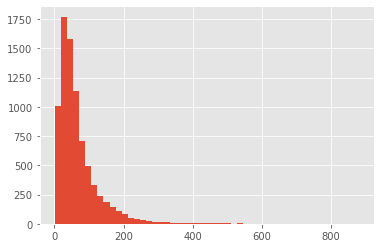

Testing
Average length of each row >> 66.75064822817632
Maximum length of each row >> 736


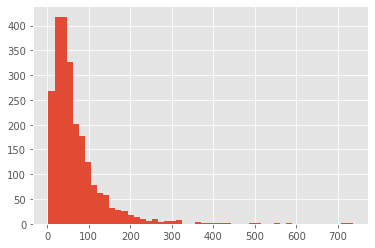

max sequence length:  882


In [28]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

23633 words are used
Training:
Average length of each row >> 53.85315292949355
Maximum length of each row >> 796


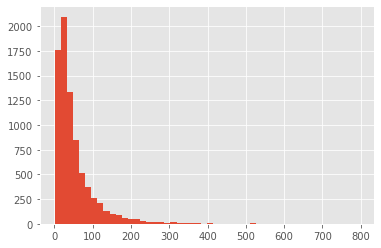

Testing
Average length of each row >> 52.32541054451167
Maximum length of each row >> 954


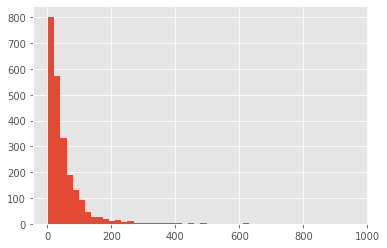

max sequence length:  954


In [29]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

14878 words are used
Training:
Average length of each row >> 27.33329195630586
Maximum length of each row >> 1758


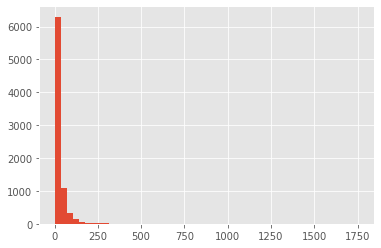

Testing
Average length of each row >> 25.2152117545376
Maximum length of each row >> 669


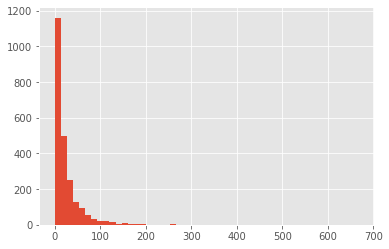

max sequence length:  1758


In [30]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

11404 words are used
Training:
Average length of each row >> 16.799155908639523
Maximum length of each row >> 477


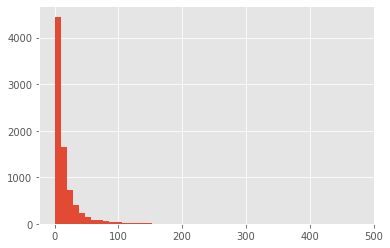

Testing
Average length of each row >> 15.95419187554019
Maximum length of each row >> 322


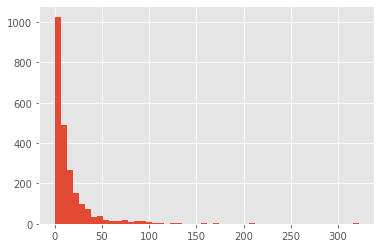

max sequence length:  477


In [31]:
df4_train_fea,df4_test_fea,df4_vocab_size,df4_maxlen = tokenize(df4_train["cleanText"],df4_test["cleanText"])

23352 words are used
Training:
Average length of each row >> 46.989199255121044
Maximum length of each row >> 782


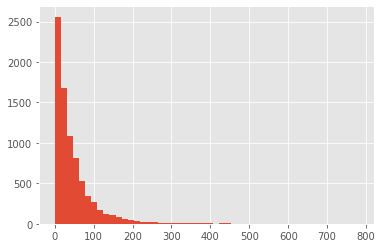

Testing
Average length of each row >> 45.676025917926566
Maximum length of each row >> 712


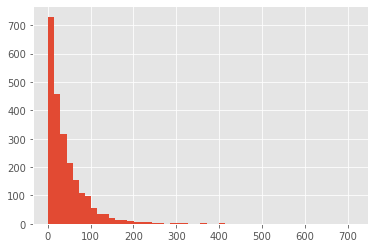

max sequence length:  782


In [32]:
merge_train_fea,merge_test_fea,merge_vocab_size,merge_maxlen = tokenize(train_merged["cleanText"],test_merged["cleanText"])

22927 words are used
Training:
Average length of each row >> 46.10837988826815
Maximum length of each row >> 796


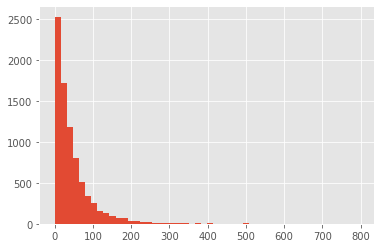

Testing
Average length of each row >> 55.46087332468655
Maximum length of each row >> 733


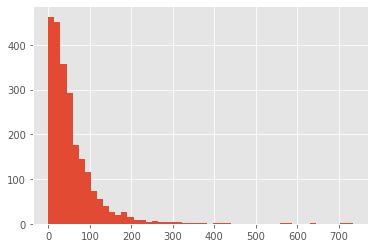

max sequence length:  796


In [50]:
merge_train_fea2,merge_test_fea2,merge_vocab_size2,merge_maxlen2 = tokenize(train_merged2["cleanText"],test_merged2["cleanText"])

## Padding

In [33]:
sequence_size = max(df1_maxlen,df2_maxlen,df3_maxlen,df4_maxlen,merge_maxlen)
print("max sequence length for software: ",sequence_size)

max sequence length for software:  1758


In [34]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

df4_train_pad = pad_sequences(df4_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_test_pad = pad_sequences(df4_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_train_label = to_categorical(df4_train.overall,num_classes=3)
df4_test_label = to_categorical(df4_test.overall,num_classes=3)

merge_train_pad = pad_sequences(merge_train_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_test_pad = pad_sequences(merge_test_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_train_label = to_categorical(train_merged.overall,num_classes=3)
merge_test_label = to_categorical(test_merged.overall,num_classes=3)

In [51]:
merge_train_pad2 = pad_sequences(merge_train_fea2,maxlen=sequence_size,padding='post',truncating='post')
merge_test_pad2 = pad_sequences(merge_test_fea2,maxlen=sequence_size,padding='post',truncating='post')
merge_train_label2 = to_categorical(train_merged2.overall,num_classes=3)
merge_test_label2 = to_categorical(test_merged2.overall,num_classes=3)

## Build LSTM Model and Train on merged train (4:2:2:2)

In [35]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 256
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,df4_vocab_size,merge_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  29572


In [36]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [37]:
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [38]:
bilstm = bilstm_model()
plot_model(bilstm)
lstm_no_hist = bilstm.fit(merge_train_pad,merge_train_label,epochs=epochs,batch_size=batch_size,validation_data=(merge_test_pad,merge_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1758, 100)         2957200   
                                                                 
 bidirectional (Bidirectiona  (None, 1758, 256)        234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 450048)            0         
                                                                 
 dense (Dense)               (None, 32)                14401568  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

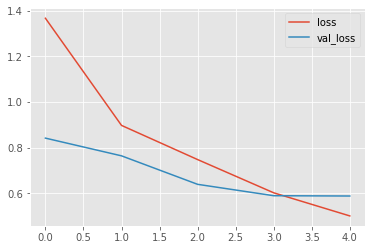

In [39]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

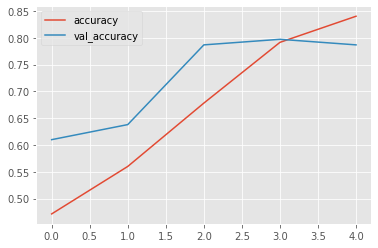

In [40]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [41]:
bilstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge_unbalanced.h5')

## Build LSTM Model and Train on merged train (7:1:1:1)

In [52]:
bilstm2 = bilstm_model()
plot_model(bilstm2)
lstm_no_hist = bilstm2.fit(merge_train_pad2,merge_train_label2,epochs=epochs,batch_size=batch_size,validation_data=(merge_test_pad2,merge_test_label2),callbacks=[es])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1758, 100)         2957200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 1758, 256)        234496    
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 450048)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                14401568  
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                      

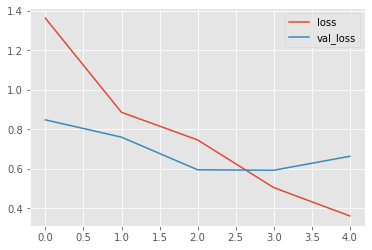

In [53]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

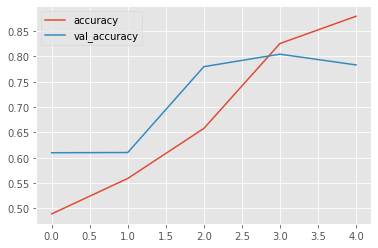

In [54]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [55]:
bilstm2.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge_unbalanced2.h5')

## Evaluate on each time period data

In [42]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df1_test_pad,df1_test_label)

73/73 [==============================] - 64s 866ms/step - loss: 1.1487 - accuracy: 0.4706


[1.1486961841583252, 0.47061365842819214]

In [46]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df2_test_pad,df2_test_label)

73/73 [==============================] - 65s 869ms/step - loss: 1.0815 - accuracy: 0.4987


[1.081507921218872, 0.4987035393714905]

In [44]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df3_test_pad,df3_test_label)

73/73 [==============================] - 66s 891ms/step - loss: 1.0381 - accuracy: 0.5069


[1.0381375551223755, 0.5069144368171692]

In [45]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge_unbalanced.h5')
load_lstm.evaluate(df4_test_pad,df4_test_label)

73/73 [==============================] - 65s 871ms/step - loss: 1.0841 - accuracy: 0.4443


[1.0840717554092407, 0.4442523717880249]

In [56]:
load_lstm2 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_merge_unbalanced2.h5')

In [57]:
load_lstm2.evaluate(df1_test_pad,df1_test_label)

73/73 [==============================] - 74s 988ms/step - loss: 1.7159 - accuracy: 0.4693


[1.7159425020217896, 0.4693171977996826]

In [58]:
load_lstm2.evaluate(df2_test_pad,df2_test_label)

73/73 [==============================] - 76s 1s/step - loss: 1.5756 - accuracy: 0.4767


[1.5755528211593628, 0.4766637980937958]

In [59]:
load_lstm2.evaluate(df3_test_pad,df3_test_label)

73/73 [==============================] - 78s 1s/step - loss: 1.5175 - accuracy: 0.4650


[1.5175153017044067, 0.46499568223953247]

In [61]:
load_lstm2.evaluate(df4_test_pad,df4_test_label)

73/73 [==============================] - 66s 899ms/step - loss: 1.3437 - accuracy: 0.4775


[1.3436706066131592, 0.47752809524536133]